In [27]:
import numpy as np
import scipy.io as sio
import scipy.optimize as opt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
def load_data():
    d = sio.loadmat('ex5data1.mat')
    return map(np.ravel, [d['X'], d['y'], d['Xval'], d['yval'], d['Xtest'], d['ytest']])


# map(func, item)函数中，item这个位置必须是一个迭代器，所以这个中括号不能去，用来凑成一个列表。

X, y, Xval, yval, Xtest, ytest = load_data()
X, y, Xval, yval, Xtest, ytest

(array([-15.93675813, -29.15297922,  36.18954863,  37.49218733,
        -48.05882945,  -8.94145794,  15.30779289, -34.70626581,
          1.38915437, -44.38375985,   7.01350208,  22.76274892]),
 array([ 2.13431051,  1.17325668, 34.35910918, 36.83795516,  2.80896507,
         2.12107248, 14.71026831,  2.61418439,  3.74017167,  3.73169131,
         7.62765885, 22.7524283 ]),
 array([-16.74653578, -14.57747075,  34.51575866, -47.01007574,
         36.97511905, -40.68611002,  -4.47201098,  26.53363489,
        -42.7976831 ,  25.37409938, -31.10955398,  27.31176864,
         -3.26386201,  -1.81827649, -40.7196624 , -50.01324365,
        -17.41177155,   3.5881937 ,   7.08548026,  46.28236902,
         14.61228909]),
 array([ 4.17020201e+00,  4.06726280e+00,  3.18730676e+01,  1.06236562e+01,
         3.18360213e+01,  4.95936972e+00,  4.45159880e+00,  2.22763185e+01,
        -4.38738274e-05,  2.05038016e+01,  3.85834476e+00,  1.93650529e+01,
         4.88376281e+00,  1.10971588e+01,  7.4617082

E:\develop\anaconda\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
E:\develop\anaconda\anaconda3\lib\site-packages\seaborn\regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


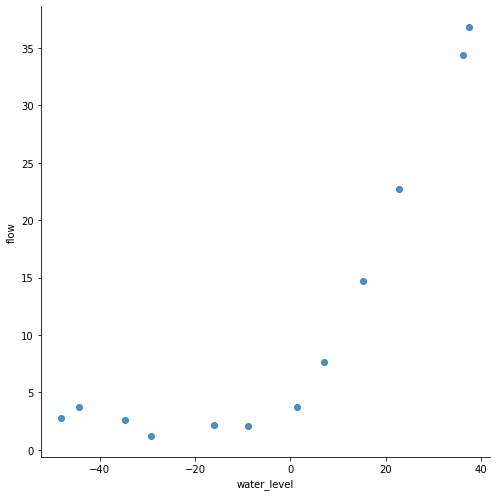

In [29]:
df = pd.DataFrame({'water_level': X, 'flow': y})  # 使用字典创建DataFrame
sns.lmplot('water_level', 'flow', data=df, fit_reg=False, size=7)  # fit_reg参数默认是True，绘制回归模型

plt.show()

In [30]:
X, Xval, Xtest = [np.insert(x.reshape(x.shape[0], 1), 0, np.ones(x.shape[0]), axis=1) for x in (X, Xval, Xtest)]
# 元组(X, Xval, Xtest)中三元素的列数不一致，如果去掉reshape就会因为这个问题报错

X

array([[  1.        , -15.93675813],
       [  1.        , -29.15297922],
       [  1.        ,  36.18954863],
       [  1.        ,  37.49218733],
       [  1.        , -48.05882945],
       [  1.        ,  -8.94145794],
       [  1.        ,  15.30779289],
       [  1.        , -34.70626581],
       [  1.        ,   1.38915437],
       [  1.        , -44.38375985],
       [  1.        ,   7.01350208],
       [  1.        ,  22.76274892]])

In [31]:
def cost(theta, X, y):
    # INPUT：参数值theta，数据X,标签y
    # OUTPUT：当前参数值下代价函数
    # TODO：根据参数和输入的数据计算代价函数

    # STEP1：获取样本个数
    m = X.shape[0]

    # STEP2：计算代价函数
    inner = (X @ theta) - y
    cost = (1 / (2 * m)) * (inner.T @ inner)

    return float(cost)


theta = np.ones(X.shape[1])
cost(theta, X, y)

303.9515255535976

In [32]:
def gradient(theta, X, y):
    # INPUT：参数值theta，数据X,标签y
    # OUTPUT：当前参数值下梯度
    # TODO：根据参数和输入的数据计算梯度

    # STEP1：获取样本个数
    m = X.shape[0]
    # theta = theta.reshape(theta.shape[0], 1)

    # STEP2：计算代价函数
    grad = (1 / m) * (X.T @ (X @ theta - y))
    return grad


gradient(theta, X, y)

array([-15.30301567, 598.16741084])

In [33]:
def regularized_cost(theta, X, y, l=1):
    m = X.shape[0]
    regularized_term = (l / (2 * m)) * np.power(theta[1:], 2).sum()
    return cost(theta, X, y) + regularized_term


def regularized_gradient(theta, X, y, l=1):
    m = X.shape[0]
    regularized_term = theta.copy()

    regularized_term[0] = 0
    regularized_term = regularized_term * l / m

    return regularized_term + gradient(theta, X, y)


regularized_gradient(theta, X, y)

array([-15.30301567, 598.25074417])

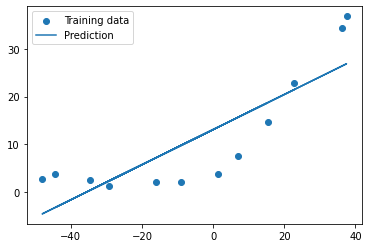

In [34]:
def linear_regression_np(X, y, l=1):
    # STEP1：初始化参数
    theta = np.ones(X.shape[1])

    # STEP2：调用优化算法拟合参数
    res = opt.minimize(fun=regularized_cost,
                       x0=theta,
                       args=(X, y, l),
                       method='TNC',
                       jac=regularized_gradient,
                       options={'disp': True})
    return res


final_theta = linear_regression_np(X, y, l=0).get('x')
b = final_theta[0]
m = final_theta[1]

plt.scatter(X[:, 1], y, label="Training data")
plt.plot(X[:, 1], X[:, 1] * m + b, label="Prediction")
plt.legend(loc=2)
plt.show()

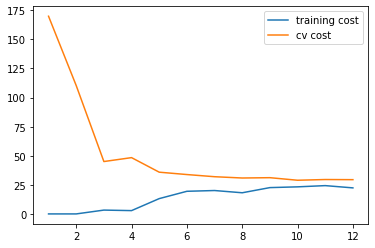

In [35]:
training_cost, cv_cost = [], []
m = X.shape[0]

for i in range(1, m + 1):
    # STEP2：计算不同样本数训练出的模型的代价
    res = linear_regression_np(X[:i, :], y[:i], l=0)

    tc = regularized_cost(res.x, X[:i, :], y[:i], l=0)
    cv = cost(res.x, Xval, yval)

    # STEP3：把计算结果存储至预先定义的数组training_cost, cv_cost中
    training_cost.append(tc)
    cv_cost.append(cv)

plt.plot(np.arange(1, m + 1), training_cost, label='training cost')
plt.plot(np.arange(1, m + 1), cv_cost, label='cv cost')
plt.legend(loc=1)
plt.show()

In [36]:
def prepare_poly_data(*args, power):
    def prepare(x):
        # 特征映射
        df = poly_features(x, power=power)

        # 归一化处理
        ndarr = np.matrix(normalize_feature(df))

        # 添加偏置项
        return np.insert(ndarr, 0, np.ones(ndarr.shape[0]), axis=1)

    return [prepare(x) for x in args]


# 特征映射函数，返回的是DataFrame
def poly_features(x, power, as_ndarray=False):
    data = {'f{}'.format(i): np.power(x, i) for i in range(1, power + 1)}
    df = pd.DataFrame(data)

    return df.as_matrix() if as_ndarray else df


# 归一化函数
def normalize_feature(df):
    return df.apply(lambda column: (column - column.mean()) / column.std())


X, y, Xval, yval, Xtest, ytest = load_data()
X_poly, Xval_poly, Xtest_poly = prepare_poly_data(X, Xval, Xtest, power=8)

# 将得到的三个矩阵转换为数组
X_poly = X_poly.A
Xval_poly = Xval_poly.A
Xtest_poly = Xtest_poly.A

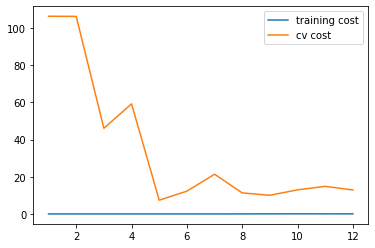

In [37]:
def plot_learning_curve(X, y, Xval, yval, l=0):
    # STEP1：初始化参数，获取样本个数，开始遍历
    training_cost, cv_cost = [], []
    m = X.shape[0]

    for i in range(1, m + 1):
        # STEP2：调用之前写好的拟合数据函数进行数据拟合
        res = linear_regression_np(X[:i, :], y[:i], l)  # 注意这里是l，那么就可以根据函数给的l值进行限制

        # STEP3：计算样本代价
        tc = cost(res.x, X[:i, :], y[:i])
        cv = cost(res.x, Xval, yval)

        # STEP3：把计算结果存储至预先定义的数组training_cost, cv_cost中
        training_cost.append(tc)
        cv_cost.append(cv)

    plt.plot(np.arange(1, m + 1), training_cost, label='training cost')
    plt.plot(np.arange(1, m + 1), cv_cost, label='cv cost')
    plt.legend(loc=1)


theta = np.ones(9)
plot_learning_curve(X_poly, y, Xval_poly, yval, l=0)  # 先不用正则化

plt.show()

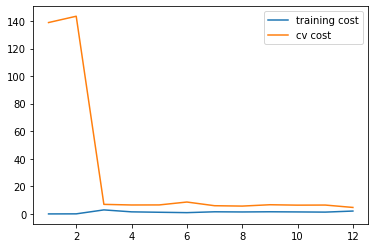

In [38]:
plot_learning_curve(X_poly, y, Xval_poly, yval, l=1)
plt.show()

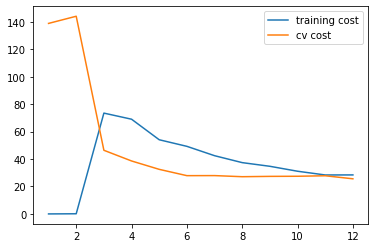

In [39]:
plot_learning_curve(X_poly, y, Xval_poly, yval, l=20)
plt.show()

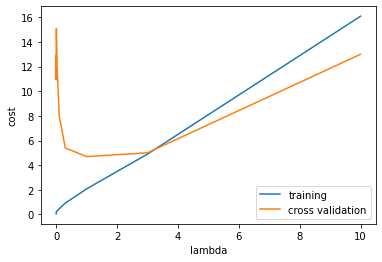

In [40]:
l_candidate = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
training_cost, cv_cost = [], []
for l in l_candidate:
    res = linear_regression_np(X_poly, y, l)

    tc = cost(res.x, X_poly, y)
    cv = cost(res.x, Xval_poly, yval)

    training_cost.append(tc)
    cv_cost.append(cv)

plt.plot(l_candidate, training_cost, label='training')
plt.plot(l_candidate, cv_cost, label='cross validation')
plt.legend(loc=4)

plt.xlabel('lambda')
plt.ylabel('cost')

plt.show()

In [41]:
# 找到使交叉验证误差最小的正则化系数
l_candidate[np.argmin(cv_cost)]

1

In [42]:
# 看一下最好的正则化系数对应的测试误差
final_res = linear_regression_np(X_poly, y, 1)
print('test cost(l={}) = {}'.format(1, cost(final_res.x, Xtest_poly, ytest)))


test cost(l=1) = 7.466293335389994
